In [57]:
import platform
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

if platform.system() == "Darwin":           # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)

#워닝 메시지
import warnings
warnings.filterwarnings('ignore')


In [58]:
df= pd.read_csv('../해커톤/Woo_data_3.csv', encoding='euc-kr')

X=df[['위안화원_시', '코스피시가', '달러위안화_시', 'WTI', '달러인덱스', '콜금리', '엔원_시']]
y=df['달러원종가']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3318 entries, 0 to 3317
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   위안화원_시   3318 non-null   float64
 1   코스피시가    3318 non-null   float64
 2   달러위안화_시  3318 non-null   float64
 3   WTI      3318 non-null   float64
 4   달러인덱스    3318 non-null   float64
 5   콜금리      3318 non-null   float64
 6   엔원_시     3318 non-null   float64
dtypes: float64(7)
memory usage: 181.6 KB


In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"전체 데이터 수 = {X.shape[0]}")
print(f'train set 데이터 수 = {X_train.shape[0]}')
print(f'test set 데이터 수 = {X_test.shape[0]}')

전체 데이터 수 = 3318
train set 데이터 수 = 2654
test set 데이터 수 = 664


In [60]:
from sklearn.preprocessing import StandardScaler

StdardScaler = StandardScaler()
X_train_std = StdardScaler.fit_transform(X_train)
X_test_std = StdardScaler.transform(X_test)


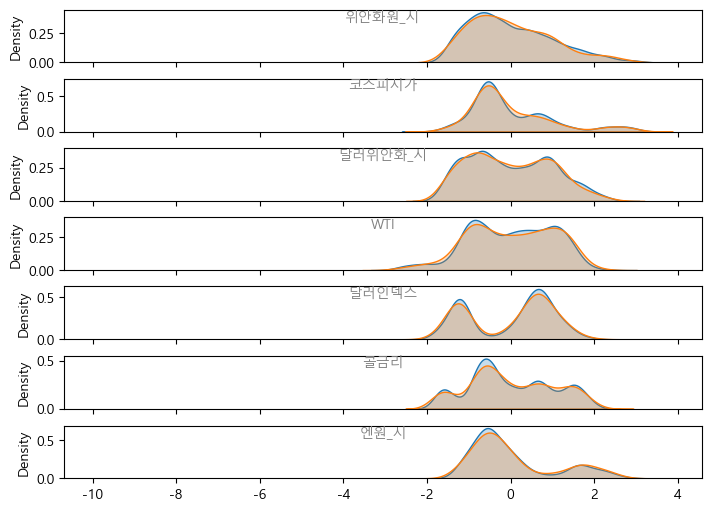

In [61]:
#cols_numerical = X.columns.tolist()
fig,axs=plt.subplots(nrows=7, figsize=(7,5), constrained_layout=True, sharex=True)
for i, ax in enumerate(axs):
    sns.kdeplot(X_train_std[:,i], fill=True, ax=ax)
    sns.kdeplot(X_test_std[:,i], fill=True, ax=ax)
    ax.text(0.5,0.8, cols_numerical[i], ha="center", transform=ax.transAxes, color='gray')
    ax.set_xlabel("")

In [ ]:
## 여기서 피쳐셀렉이 또 왜 들어가는 거지??? 

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

sclaer = MinMaxScaler()
lgb=LGBMRegressor()
feature = RFE(LinearRegression(), n_features_to_select=7)

pipe = Pipeline([
    ('scaler',sclaer),
    ('feature_select',feature),
    ('model', lgb)
])

param = {
    'model__max_depth': [2,3,5],
    'model__learning_rate' : [0.1,0.01]
}

grid = GridSearchCV(estimator=pipe, param_grid=param, cv=5)
grid.fit(X_train,y_train)

In [74]:
grid.best_params_

{'model__learning_rate': 0.1, 'model__max_depth': 5}

In [89]:
# 왜 이렇게 나올지??
y_pred=grid.predict(X_test)

# y_pred = best_lgb_model.predict(X_test) 이거랑 같은 뜻인데 왜 에러가 나지?

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [94]:
best_learning_rate = grid.best_params_['model__learning_rate']
best_max_depth = grid.best_params_['model__max_depth']

best_lgb_model = LGBMRegressor(learning_rate=best_learning_rate, max_depth=best_max_depth)


In [ ]:
best_lgb_model.fit(X_train, y_train)
y_pred = best_lgb_model.predict(X_test)

In [97]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R2-squared: {r2:.2f}")

Mean Squared Error: 60.50
R2-squared: 0.99


In [98]:
result=pd.DataFrame({'y':y_test.values,'y_pred':y_pred, 'diff':np.abs(y_test.values-y_pred)})
result.sort_values(by=['diff'], ascending=False)

,y,y_pred,diff
522,1421.34,1345.091203,76.248797
325,1164.50,1129.962040,34.537960
445,1179.85,1149.571094,30.278906
506,1107.15,1078.183251,28.966749
404,1253.50,1281.019359,27.519359
...,...,...,...
305,1023.12,1023.043775,0.076225
489,1215.07,1215.134792,0.064792
437,1228.94,1228.875325,0.064675
137,1080.50,1080.479419,0.020581


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


<Axes: >

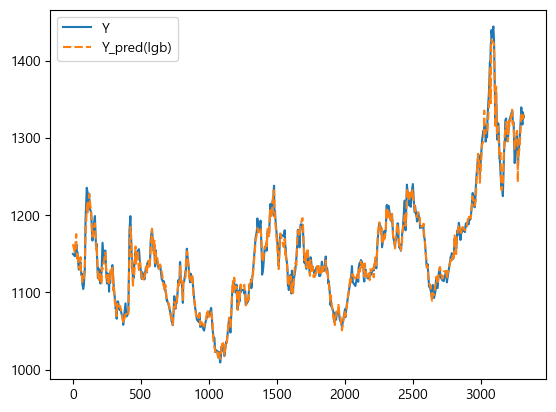

In [100]:
# 스켈링한 X_train 

y_pred = best_lgb_model.predict(X_test)
lgb_df = pd.DataFrame(data={'Y':y_test, 'Y_pred(lgb)':y_pred,})
#'diff(lgb)':np.round(np.abs(y_test-y_pred),2
sns.lineplot(data=lgb_df )

In [109]:
# 스케일링 + 선형회귀 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_1=df[['위안화원_시', '코스피시가', '달러위안화_시', 'WTI', '달러인덱스', '콜금리', '엔원_시']]
y_1=df['달러원종가']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

pipeline_1 = Pipeline([
    ('scaler', MinMaxScaler()),  # Min-Max scaler
    ('regressor', LinearRegression())  # Linear regression model
])

pipeline_1.fit(X_train_1,y_train_1)
y_pred_1=pipeline_1.predict(X_test_1)

coefficients = pipeline_1['regressor'].coef_
intercept = pipeline_1['regressor'].intercept_
mse= mean_squared_error(y_test_1,y_pred_1)
rmse=np.sqrt(mse)

print(f"MSE : {mse:.3f}, RMSE:{rmse:.3f}")
print(f"Variance score:{r2_score(y_test_1,y_pred_1):.3f}")
print("Coefficients (Weights):", coefficients)
print("Intercept (Bias):", intercept)

MSE : 731.694, RMSE:27.050
Variance score:0.871
Coefficients (Weights): [263.78029438   4.47231796 226.56583951  -0.83465662   1.69398467
   7.68538659  -2.98140162]
Intercept (Bias): 960.8086423643653


In [112]:
coef=pd.Series(data=np.round(pipeline_1['regressor'].coef_,2), index=X.columns)
coef

위안화원_시     263.78
코스피시가        4.47
달러위안화_시    226.57
WTI         -0.83
달러인덱스        1.69
콜금리          7.69
엔원_시        -2.98
dtype: float64

레이블(대상 변수)이 연속적인 실수값인 회귀 문제를 해결하기 위해 다양한 회귀 모델을 사용할 수 있습니다. 어떤 모델을 선택할지는 데이터와 문제의 특성에 따라 다를 수 있지만, 아래에 일반적으로 사용되는 회귀 모델 중 일부를 나열하겠습니다:

1. **선형 회귀 (Linear Regression)**:
   - 데이터 간의 선형 관계를 모델링하는 가장 간단한 회귀 모델입니다.
   - 예측값은 입력 특성의 선형 조합으로 계산됩니다.
   - Ridge Regression, Lasso Regression 등과 같은 정규화된 선형 회귀 모델도 있습니다.

2. **결정 트리 회귀 (Decision Tree Regression)**:
   - 데이터를 분할하여 트리 구조로 모델링하는 방법입니다.
   - 데이터의 비선형 관계를 잘 모델링할 수 있습니다.

3. **랜덤 포레스트 회귀 (Random Forest Regression)**:
   - 여러 개의 결정 트리를 앙상블한 모델로, 예측의 안정성과 정확도를 높일 수 있습니다.

4. **그래디언트 부스팅 회귀 (Gradient Boosting Regression)**:
   - 여러 개의 약한 예측 모델을 조합하여 강력한 예측 모델을 만드는 앙상블 기법입니다.
   - 예를 들어, XGBoost, LightGBM, CatBoost와 같은 라이브러리를 사용할 수 있습니다.

5. **서포트 벡터 머신 회귀 (Support Vector Machine Regression)**:
   - 주어진 데이터 포인트와 가장 가까운 서포트 벡터들 사이의 마진을 최대화하는 회귀 모델입니다.

6. **신경망 기반 회귀 (Neural Network Regression)**:
   - 딥 러닝 기술을 활용하여 복잡한 비선형 관계를 모델링할 수 있습니다.
   - 인공 신경망을 사용하는 방법 중 하나입니다.

모델 선택은 데이터의 특성, 모델의 복잡성, 예측 정확도, 계산 비용 등을 고려하여 결정해야 합니다. 또한 하이퍼파라미터 튜닝과 교차 검증을 사용하여 모델의 성능을 최적화할 수 있습니다. 문제에 가장 적합한 모델을 선택하려면 데이터와 문제의 도메인에 대한 이해가 중요합니다.